###Problems encounter and solved

1. initially there is very high loss that means the nn is confidently   very wrong so we corrected that by multiplying 0 to b2 and a small number(0.001) to w2


2. Value of h
    tanh is very very active the preactivation takes a broad range, maximum values are squashed into eithr -1 or 1  which is not good for our NN
    if this happens maximum no of neurons will never get activated.
    to solve this we multiply b1 and w1 with small numbers like(0.01)

3. Batch normalization
    used to train large neural networks
    if you want the hpreact to be roughly gaussian why not take the hidden states and normalize them to be gaussian 
    we will add bngain and bnbias to the hpreact to normalise them


    When you are using batch noralization layer then biases have no role in the calculations so you do not use the bais to prevent unnecessary calculations because it doesn't have any significance

In [ ]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
words=open('names.txt','r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [118]:
len(words)


32033

In [119]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [120]:
#Build the dataset
block_size=3
def build_dataset(words):
    X,Y=[],[]
    for w in words:

        context = [0]*block_size
        for ch in w +'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:]+[ix]

    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr=build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
#MLP revisited
n_embd=10
n_hidden=200
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,n_embd),generator=g)
W1=torch.randn((n_embd*block_size,n_hidden),generator=g)*(5/3)/((n_embd *block_size)**0.5)
# b1=torch.randn((n_hidden),generator=g)*0.01
W2=torch.randn((n_hidden,vocab_size),generator=g)*0.01
b2=torch.randn((vocab_size),generator=g)*0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running=torch.ones((1,n_hidden))
bnstd_running=torch.ones((1,n_hidden))
parameters=[C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True
    

11897


In [122]:
hpreact.mean(0,keepdims=True).shape,hpreact.std(0,keepdims=True).shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [ ]:
max_steps=200000
batch_size=32
lossi=[]

for i in range(max_steps):
    #Minibatch generator
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix]

    #Forward pass
    emb=C[Xb]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=embcat@W1 #+b1
    bnmeani=hpreact.mean(0,keepdims=True)
    bnstdi=hpreact.std(0,keepdims=True)
    hpreact=bngain * (hpreact-bnmeani) / (bnstdi) + bnbias

    with torch.no_grad():
        bnmean_running=0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi

    h=torch.tanh(hpreact)
    logits=h@W2+b2
    loss= F.cross_entropy(logits,Ytr[ix])

    #Backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #Update
    lr = 0.01 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break



tensor(0.0053) tensor(0.9915)
tensor(-0.0038) tensor(3.1303)


(array([1.53797847e-05, 0.00000000e+00, 3.84494616e-05, 3.84494616e-05,
        1.07658493e-04, 1.38418062e-04, 1.61487739e-04, 3.15285585e-04,
        4.99843001e-04, 9.38166864e-04, 1.33035137e-03, 2.00706190e-03,
        3.81418659e-03, 5.71359000e-03, 8.04362737e-03, 1.23422772e-02,
        1.80097278e-02, 2.56381010e-02, 3.54042643e-02, 4.92230008e-02,
        6.34800611e-02, 8.01209881e-02, 9.94303078e-02, 1.15440664e-01,
        1.29144052e-01, 1.36641697e-01, 1.36034195e-01, 1.26398760e-01,
        1.12049421e-01, 9.42011810e-02, 7.58684777e-02, 5.93198294e-02,
        4.48090026e-02, 3.23283073e-02, 2.26005935e-02, 1.59026973e-02,
        1.04659435e-02, 7.28232803e-03, 4.43706787e-03, 3.36817284e-03,
        1.96092254e-03, 1.06120514e-03, 7.76679125e-04, 4.30633970e-04,
        2.69146231e-04, 1.84557416e-04, 9.99686002e-05, 4.61393540e-05,
        3.07595693e-05, 1.53797847e-05]),
 array([-16.8097496 , -16.15954544, -15.50934128, -14.85913712,
        -14.20893295, -13.5587

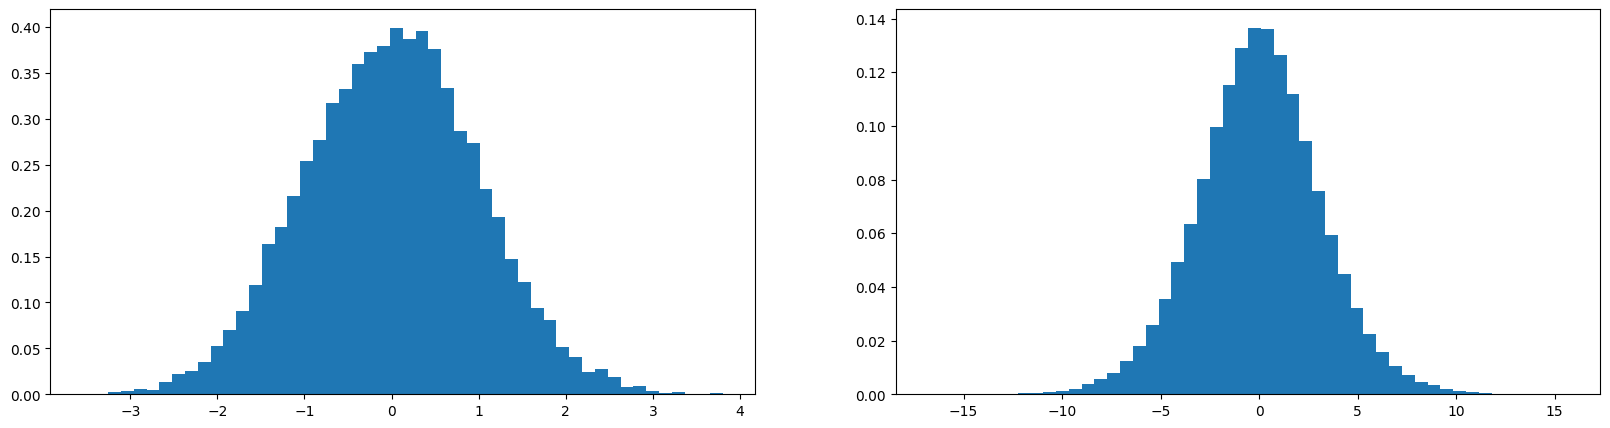

In [124]:
#How to get the values which we multiplied with weights and biases
x=torch.randn(1000,10)
w=torch.randn(10,200)
y= x @ w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True)

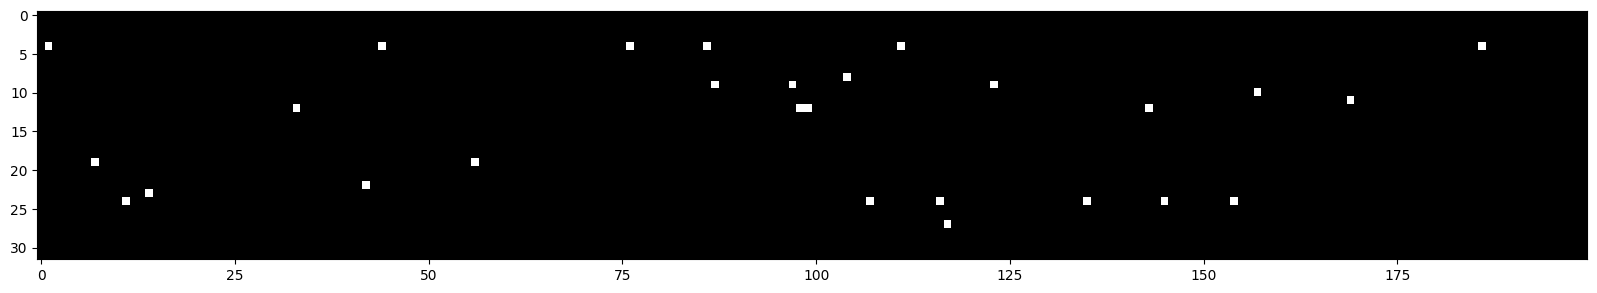

In [125]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

(array([153., 196., 174., 171., 173., 173., 131., 138., 130., 124., 113.,
        140., 124., 113., 109., 120., 120., 104., 123., 105., 105., 104.,
         94., 117., 111., 111.,  85.,  88.,  72.,  98.,  94., 127., 105.,
         88., 111., 110., 127., 112., 103., 124., 134., 130., 132., 149.,
        151., 179., 158., 192., 196., 159.]),
 array([-9.97799933e-01, -9.57872003e-01, -9.17944074e-01, -8.78016144e-01,
        -8.38088214e-01, -7.98160285e-01, -7.58232355e-01, -7.18304425e-01,
        -6.78376496e-01, -6.38448566e-01, -5.98520637e-01, -5.58592707e-01,
        -5.18664777e-01, -4.78736848e-01, -4.38808918e-01, -3.98880988e-01,
        -3.58953059e-01, -3.19025129e-01, -2.79097199e-01, -2.39169270e-01,
        -1.99241340e-01, -1.59313411e-01, -1.19385481e-01, -7.94575512e-02,
        -3.95296216e-02,  3.98308039e-04,  4.03262377e-02,  8.02541673e-02,
         1.20182097e-01,  1.60110027e-01,  2.00037956e-01,  2.39965886e-01,
         2.79893816e-01,  3.19821745e-01,  3.59749

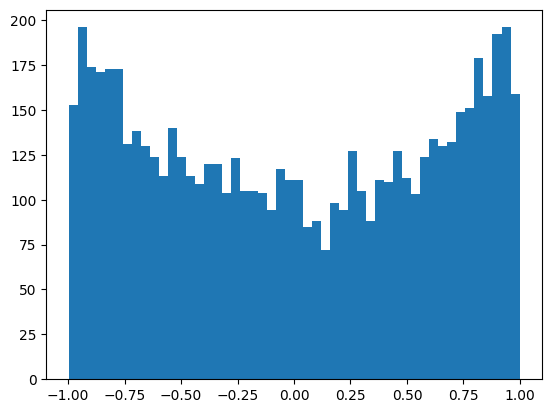

In [126]:
plt.hist(h.view(-1).tolist(),50)

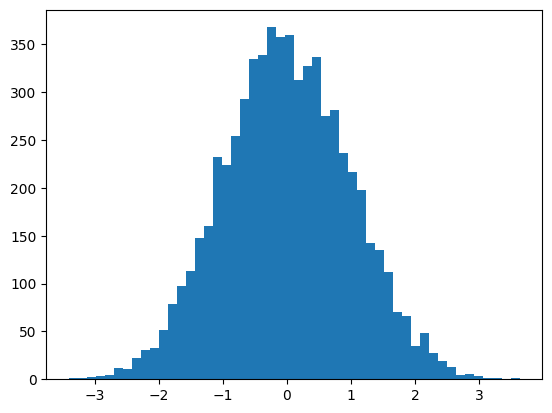

In [127]:
plt.hist(hpreact.view(-1).tolist(),50);

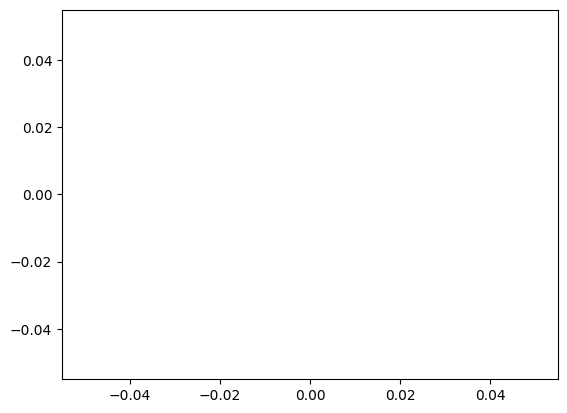

In [128]:
plt.plot(lossi)

In [ ]:
#calibrate the batch norm at the end of training

# with torch.no_grad():
#     #pass the training set through
#     emb = C[Xtr]
#     embcat=emb.view(emb.shape[0],-1)
#     hpreact=embcat@W1+b1
#     bnmean=hpreact.mean(0,keepdim=True)
#     bnstd=hpreact.std(0,keepdim=True)



### WE have skipped this step by using bnstd running and bnmean running the the above loop so  that we donot have to terate it all over once again 

In [129]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat=emb.view(emb.shape[0],-1)
    hpreact= embcat@W1 + b1
    hpreact=bngain * (hpreact-bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split,loss.item())

split_loss('train')
split_loss('dev')



train 3.3055129051208496
dev 3.304720640182495


In [130]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

cbrpzhxqtbfhqvufkwmrpxqthtykhkcfsskejrzhnbnfqpwsyhc.
vgqeiunrzmuqptcmziivduxlhggphhbmgfoin.
qbqjtzsrlivwawvvdbquwqzehogdjaryxixfkqeupiusdbwed.
ecxiatgtlffhysflquhpagmovdjhksyjrpmqqosozswjcojq.
wycjsfrenqkpfsadlnuo.
zoebsrkoiazhrynhg.
opklhynrxph.
xqioloqbprbvbwdn.
ipyqmuitjgbvfpzpddgpycsislqwkkmcrnzauqnyjydpk.
kvweskatikzamdtevl.
ky.
qdyctoorowooktbymomokfbfcj.
zoinhzcs.
nu.
eoaiunqqeroqci.
icjzykbadyieluglc.
nwzyzdjokhnlhjjqsxmuadmtjhvtoiawlwuw.
xisxwrdfv.
zphtzbiuzzsrvgmknbfyntiysfgdgkgwmj.
pqgcrvdhpvdafpsdvkhzkxkimtvoocjupgawjmjgjwgvjflwkewtxjrclxdytpvhgqllyuil.


In [131]:
#_______________________SUMMARY___________________

In [132]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  
  n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
  

47024


In [135]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.0679


layer 2 (      Tanh): mean -0.01, std 0.64, saturated: 3.56%
layer 5 (      Tanh): mean -0.00, std 0.65, saturated: 3.28%
layer 8 (      Tanh): mean -0.00, std 0.66, saturated: 2.72%
layer 11 (      Tanh): mean +0.00, std 0.66, saturated: 2.03%
layer 14 (      Tanh): mean +0.00, std 0.67, saturated: 1.44%


Text(0.5, 1.0, 'activation distribution')

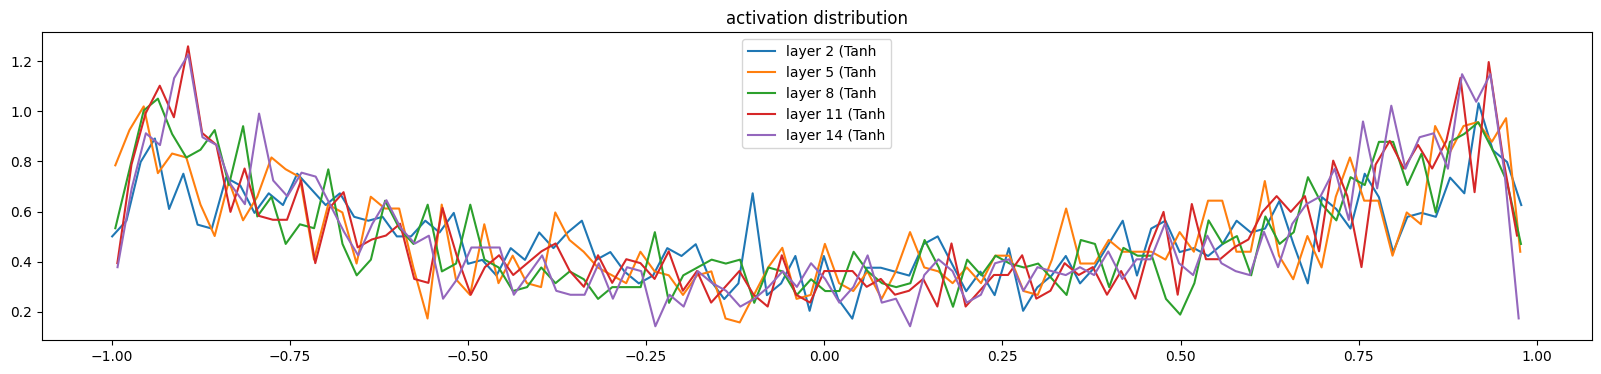

In [136]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.515475e-03
layer 5 (      Tanh): mean +0.000000, std 2.310346e-03
layer 8 (      Tanh): mean -0.000000, std 2.128938e-03
layer 11 (      Tanh): mean +0.000000, std 1.952366e-03
layer 14 (      Tanh): mean -0.000000, std 1.968873e-03


Text(0.5, 1.0, 'gradient distribution')

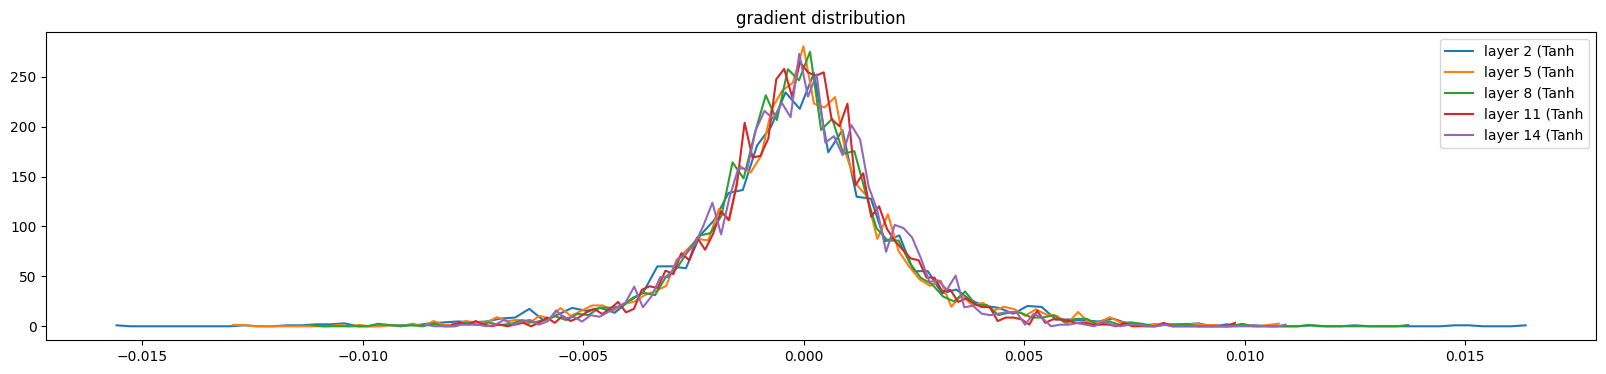

In [137]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 9.435022e-03 | grad:data ratio 9.409422e-03
weight  (30, 100) | mean -0.000078 | std 9.090256e-03 | grad:data ratio 4.537320e-02
weight (100, 100) | mean +0.000086 | std 6.189678e-03 | grad:data ratio 5.519662e-02
weight (100, 100) | mean -0.000072 | std 5.332731e-03 | grad:data ratio 4.838394e-02
weight (100, 100) | mean -0.000084 | std 4.977771e-03 | grad:data ratio 4.578577e-02
weight (100, 100) | mean -0.000016 | std 4.450822e-03 | grad:data ratio 4.133123e-02
weight  (100, 27) | mean -0.000124 | std 8.942280e-03 | grad:data ratio 7.084843e-02


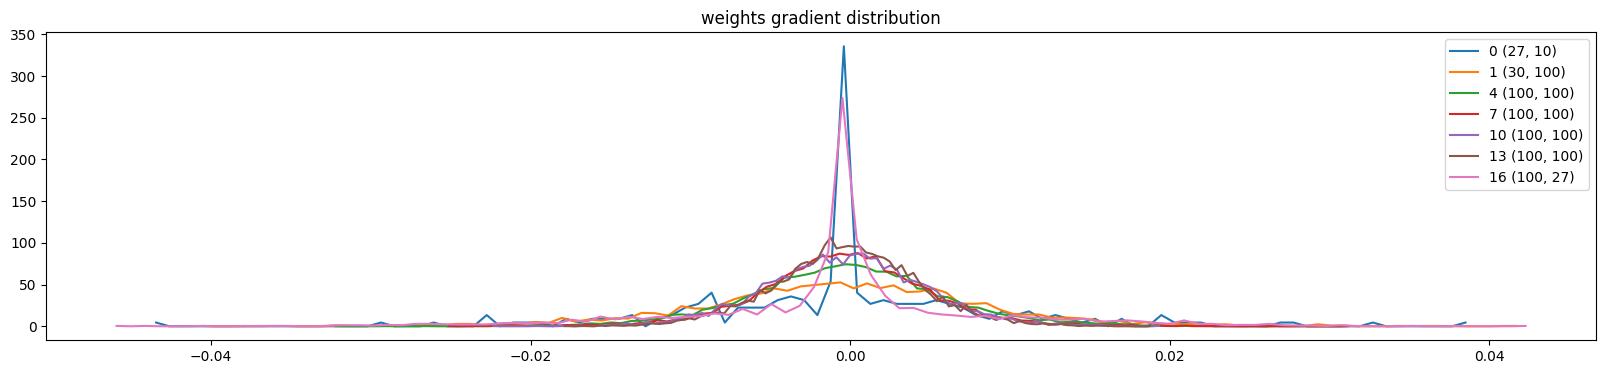

In [138]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

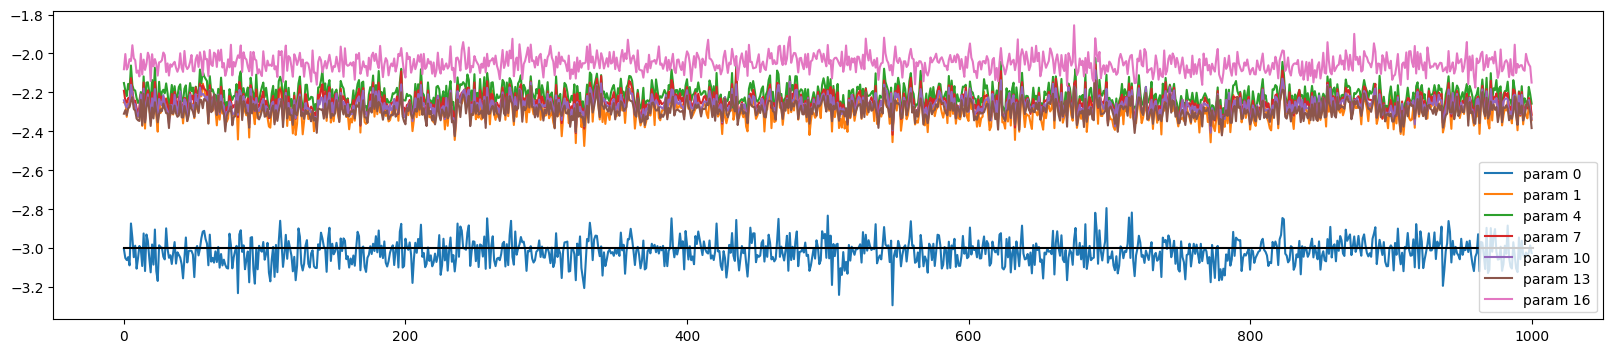

In [139]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [140]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.2552356719970703
val 2.2627205848693848


In [141]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amelle.
khi.
mri.
reety.
salessa.
jazhnte.
amery.
chareei.
nellaishchaiiv.
kaleigh.
ham.
evin.
qhinn.
shorlei.
jadbi.
warell.
dearyxi.
jayek.
insle.
